# Montaje de los datos

De tal manera de que los experimentos sean compatibles con el directorio de archivos definido, debe poseer una carpeta llamada "myocardium-segmentation" y en su interior las imagenes de entrenamiento, validación y testing. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Instalación de keras-unet y RAdam


In [0]:
pip install git+https://github.com/karolzak/keras-unet

  Cloning https://github.com/karolzak/keras-unet to /tmp/pip-req-build-5rvx34bg
  Running command git clone -q https://github.com/karolzak/keras-unet /tmp/pip-req-build-5rvx34bg
  Created wheel for keras-unet: filename=keras_unet-0.0.7-cp36-none-any.whl size=11848 sha256=1e70db9fab73db3c9f0cb327a8de274f364acb6bc011f5182626cb57974a461b
  Stored in directory: /tmp/pip-ephem-wheel-cache-y12rl99k/wheels/b3/3a/85/c3df1c96b5d83dcd2c09b634e72a98cafcf12a52501ac5cd77
Successfully built keras-unet


In [0]:
pip install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=48faf685b3db88570900cc8cb076380eb1b0645ca3a4bd2623b6e725534bd5f6
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [0]:
import keras as K
from keras import Model
from keras.layers import Layer
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.applications.vgg16 import VGG16 
from keras.layers import concatenate
from keras import Input
import numpy as np
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
from keras.backend import flatten
import tensorflow as tf
from keras_unet.losses import jaccard_distance
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras.optimizers import Adam, SGD
from keras_unet.utils import plot_imgs
from keras.preprocessing.image import ImageDataGenerator
from keras_radam import RAdam
from keras.losses import categorical_crossentropy

Using TensorFlow backend.


In [0]:
config = tf.ConfigProto( device_count = {'GPU': 156 , 'CPU': 156} ) 
sess = tf.Session(config=config) 
K.backend.set_session(sess)

# Categorical Focal Loss

Implementación de Focal Loss en base a la publicación original de esta función de costos. El código es extraído de https://github.com/umbertogriffo/focal-loss-keras. 

In [0]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.backend.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.backend.epsilon()
        y_pred = K.backend.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.backend.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.backend.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.backend.sum(loss, axis=1)

    return categorical_focal_loss_fixed

# Iou por clase

Métrica de IoU que calcula el promedio del IoU para cada una de las capas de salida.

In [0]:
def per_class_iou(y_true, y_pred, smooth=1.):
    n_classes = y_pred.shape[3]
    total = 0
    for class_number in range(n_classes):
        y_true_f = K.backend.flatten(y_true[:, :, :, class_number])
        y_pred_f = K.backend.flatten(y_pred[:, :, :, class_number])
        intersection = K.backend.sum(y_true_f * y_pred_f)
        total += (intersection + smooth) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f) - intersection + smooth)
    return total/3

# Jaccard Distance por clase

Definición alternativa de Jaccard Distance aplicada por capa. Se considera la utilización de la implementación de Keras de esta función de costos para cada una de las capas. Al aplicar la función original de Keras sobre el tensor completo se hace un flattening que empeora el desbalance de clases.

In [0]:
def per_class_jaccard_distance(y_true, y_pred,smooth=100):
  n_classes = y_pred.shape[3]
  total = 0
  for class_number in range(n_classes):
    total += jaccard_distance(y_true[:,:,:,class_number], y_pred[:,:,:,class_number], smooth)
  return total/3

# Definición del modelo

Definición del modelo a utilizar: UNet + VGG-16 en etapa de encoding. La definición incluye la utilización de las siguientes métricas:



*   Per class IoU (IoU promedio adaptado)
*   Dice score (Implementación Keras)
*   IoU Thresholded (Implementación Keras)

La función UNET1_VGG16 retorna el modelo compilado considerando RAdam como optimizador, la función de costos (que varía en función del experimento) y las métricas definidas anteriormente.



In [0]:
class Gray2VGGInput(Layer):
    """Custom conversion layer"""
    def build(self, x):
        self.image_mean = K.backend.variable(value=np.array([103.939, 116.779, 123.68]).reshape([1,1,1,3]).astype('float32'), 
                                     dtype='float32', 
                                     name='imageNet_mean' )
        self.built = True
        return
    def call(self, x):
        rgb_x = concatenate([x,x,x], axis=-1 )
        norm_x = rgb_x - self.image_mean
        return norm_x

    def compute_output_shape(self, input_shape):
        return input_shape[:3] + (3,)


def UNET1_VGG16(img_rows=256, img_cols=256):
    ''' 
    UNET with pretrained layers from VGG16
    '''
    def upsampleLayer(in_layer, concat_layer, input_size):
        '''
        Upsampling (=Decoder) layer building block
        Parameters
        ----------
        in_layer: input layer
        concat_layer: layer with which to concatenate
        input_size: input size fot convolution
        '''
        upsample = Conv2DTranspose(input_size, (2, 2), strides=(2, 2), padding='same')(in_layer)    
        upsample = concatenate([upsample, concat_layer])
        conv = Conv2D(input_size, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(upsample)
        conv = BatchNormalization()(conv)

        ######## DROPOUT ##########
        conv = Dropout(rate=0.4)(conv)
        conv = Conv2D(input_size, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
        conv = BatchNormalization()(conv)
        return conv

    #--------
    #INPUT
    #--------
    #batch, height, width, channels
    inputs_1 = Input((img_rows, img_cols, 1))

    #-----------------------
    #INPUT CONVERTER & VGG16
    #-----------------------
    inputs_3 = Gray2VGGInput(name='gray_to_rgb')(inputs_1)  #shape=(img_rows, img_cols, 3)
    base_VGG16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs_3,classes=3)

    #--------
    #DECODER
    #--------
    c1 = base_VGG16.get_layer("block1_conv2").output #(None, 256, 256, 64)
    c2 = base_VGG16.get_layer("block2_conv2").output #(None, 432, 616, 128) 
    c3 = base_VGG16.get_layer("block3_conv2").output #(None, 216, 308, 256) 
    c4 = base_VGG16.get_layer("block4_conv2").output #(None, 108, 154, 512) 

    #--------
    # BOTTLENECK
    #--------
    c5 = base_VGG16.get_layer("block5_conv2").output #(None, 54, 77, 512)

    #--------
    # ENCODER
    #--------    
    c6 = upsampleLayer(in_layer=c5, concat_layer=c4, input_size=512)
    c7 = upsampleLayer(in_layer=c6, concat_layer=c3, input_size=256)
    c8 = upsampleLayer(in_layer=c7, concat_layer=c2, input_size=128)
    c9 = upsampleLayer(in_layer=c8, concat_layer=c1, input_size=64)
    #--------
    # DENSE OUTPUT
    #--------
    out_channels=3
    outputs = Conv2D(out_channels, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs_1], outputs=[outputs])

    # Freeze layers
    for layer in model.layers[:16]:
        layer.trainable = False

    ############ LOSS & METRICS DEFINITION ############
    model.compile(optimizer=RAdam(), 
                  loss=[per_class_jaccard_distance], 
                  metrics=[per_class_iou, iou_thresholded, dice_coef])

    return model

In [0]:
model=UNET1_VGG16()
model.summary()





58892288/58889256 [==============================] - 2s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
gray_to_rgb (Gray2VGGInput)     (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        gray_to_rgb[0][0]                
____

# Carga y reshape de las imágenes

Se cargan los datos de entrenamiento, validación y testing en memoria. Además, 
se efectúa un reshape de tal manera que las dimensiones correspondan con la definición del modelo.

In [0]:
directory= '/content/drive/My Drive/myocardium-segmentation/'

X_test=np.load(directory + 'test_imgs.npy')
y_test=np.load(directory + 'test_annot.npy')

X_train=np.load(directory + 'train_imgs.npy')
y_train=np.load(directory + 'train_annot.npy')

X_val=np.load(directory + 'val_imgs.npy')
y_val=np.load(directory + 'val_annot.npy')

In [0]:
X_test = X_test.reshape(1240,256,256,1)
y_test = y_test.reshape(1240,256,256,1)

X_train = X_train.reshape(4564,256,256,1)
y_train = y_train.reshape(4564,256,256,1)

X_val = X_val.reshape(502,256,256,1)
y_val = y_val.reshape(502,256,256,1)

In [0]:
from keras.utils import to_categorical
y_test = to_categorical(y_test,num_classes=3)
y_train = to_categorical(y_train,num_classes=3)
y_val = to_categorical(y_val,num_classes=3)


# Callbacks

Keras provee la funcionalidad de Callbacks. Cada callback se ejecuta cuando algún evento ocurre. Se utilizan 4 tipos de callbacks.

*   ModelCheckpoint: Guarda el modelo después de cada epoch. Si en alguna epoch el modelo no muestra mejoras en términos de validation loss el modelo NO se guardará puesto que se considerará que la versión previa es mejor.
*   TensorBoard: Permite almacenar los registros del entrenamiento en un formato apto para su visualización mediante Tensorboard.
*   ReduceLROnPlateau: Disminuye la tasa de aprendizaje cuando se ha alcanzado convergencia de tal manera de no perturbar de sobremanera el aprendizaje llegado tal punto.
*   EarlyStopping: Detiene el entrenamiento si es que ha pasado una cierta cantidad de epochs sin mejoras en el modelo



In [0]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau

LOG_DIR = 'logs'
model_filename = 'jaccard_distance_dropout_rate_05'
callback_checkpoint = ModelCheckpoint(
    directory+ 'results/models/'+ model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

tensorboard_callback = TensorBoard(log_dir=LOG_DIR)
reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor=0.75, patience=1, verbose=1, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')


# Data augmentation

Utiliza una implementación de terceros (https://github.com/karolzak/keras-unet) que entrega un DataGenerator de Keras. Este DataGenerator se encarga de realizar tareas de aumentación de los datos. Se considera la generación de nuevas imagenes de entrenamiento mediante rotaciones, cambios en ancho y largo, zoom, reflexiones horizontales, reflexiones verticales y relleno de imagenes.

In [0]:
from keras_unet.utils import get_augmented

batch_size = 32
train_gen = get_augmented(
    X_train, y_train, batch_size=batch_size,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))


# Entrenamiento

Se fija arbitrariamente una cantidad máxima de 20 epochs y suficientes steps por epoch de tal manera de recorrer el dataset de entrenamiento completo luego de cada epoch. El entrenamiento del modelo se hace mediante el método fit_generator de tal manera de usar el DataGenerator que genera los datos aumentados. Además, se agregan los callbacks al proceso de entrenamiento.

In [0]:
epochs=15
steps_per_epoch = X_train.shape[0]/batch_size
result = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch,
                                     validation_data=(X_val, y_val),
                                     callbacks=[reduce_learning_rate,tensorboard_callback, early_stopping])





Epoch 1/15
 82/142 [================>.............] - ETA: 33s - loss: 43.4730 - per_class_iou: 0.1334 - iou_thresholded: 0.2317 - dice_coef: 0.3731

# Guardado de pesos

Fragmento de código opcional que permite guardar los pesos del modelo ya entrenado en cierto directorio.

In [0]:
model.save_weights(directory+ 'results/models/jaccard_dropout_05.h5')

# Métricas

Implementación alternativa de las mismas métricas utilizadas en el modelo. La diferencia radica es que estos cálculos se hacen en CPU y no en GPU de tal manera de distribuir de mejor manera el uso de memoria. Además, se incluye una función (implementada por nosotros) que extrae las estadísticas para la evaluación del modelo.

In [0]:
def plot_image_result(index, img_true, img_pred, title=''):
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(title)
    axs[0].imshow(img_true, cmap='gray')
    axs[0].set(title=f'Ground truth {index}')
    axs[1].imshow(img_pred, cmap='gray')
    axs[1].set(title=f'Pred {index}')
    plt.savefig('exp.png')
    plt.show()


def np_iou(y_true, y_pred, smooth=1.):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth)


def np_dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)


def np_iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred[y_pred > threshold] = 1
    y_pred[y_pred <= threshold] = 0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth)


def extract_statistics(y_test, y_pred, plot_examples=False, plot_best_worst=False):
    # Plotting 5 random samples, mask number k
    if plot_examples:
        selection = np.random.randint(0, y_test.shape[0], size=2)
        for i in selection:
            plot_image_result(i, y_test[i, :, :, 1], y_pred[i, :, :, 1])

    for metric in [np_iou, np_dice_coef, np_iou_thresholded]:

        print(f"USING {metric}")

        worst_result, worst_iou, best_iou, best_result = None, None, None, None
        # Extracts the metric per class, applies mean, and then applies mean over images scores
        metric_result = []
        for class_number in [0, 1, 2]:
            class_scores = []
            for i in range(y_test.shape[0]):
                class_scores.append(metric(y_test[i, :, :, class_number], y_pred[i, :, :, class_number]))

            class_mean_iou = np.mean(class_scores)
            class_std_iou = np.std(class_scores)
            print(f"For class {class_number}: {class_mean_iou}+-{class_std_iou}")
            metric_result.append(class_mean_iou)

            if class_number == 1:
                worst_result, worst_iou = np.argmin(class_scores), np.min(class_scores)
                best_result, best_iou = np.argmax(class_scores), np.max(class_scores)
        print("Mean and std of scores per class: {}".format(np.mean(metric_result)))

        # Extracts the metric for image and the applies mean
        images_scores = []
        for i in range(y_test.shape[0]):
            images_scores.append(metric(y_test[i, :, :, :], y_pred[i, :, :, :]))
        mean = np.mean(images_scores)
        std = np.std(images_scores)
        print(f"Global IoU: {mean} +/- {std}")

        if plot_best_worst:
            plot_image_result(worst_result,
                              y_test[worst_result, :, :, 1],
                              y_pred[worst_result, :, :, 1],
                              title=f'Worst result\nMyocardium iou: {worst_iou:.3f} - Image IoU: {images_scores[worst_result]:.3f}')
            plot_image_result(best_result,
                              y_test[best_result, :, :, 1],
                              y_pred[best_result, :, :, 1],
                              title=f'Best result\nMyocardium iou: {best_iou:.3f} - Image IoU: {images_scores[best_result]:.3f}')

        print("------------------------------")


## Resultados

La evolución del error y las métricas tanto en el conjunto de entrenamiento como el de validación son guardados en un archivo pickle de tal manera de llevar un registro que permita recrear las curvas de aprendizaje.

In [0]:
import pickle
model_name = 'categorical_crossentropy.pkl'
with open(directory + 'results/history/' + model_name, 'wb') as f:
  pickle.dump(result.history, f)


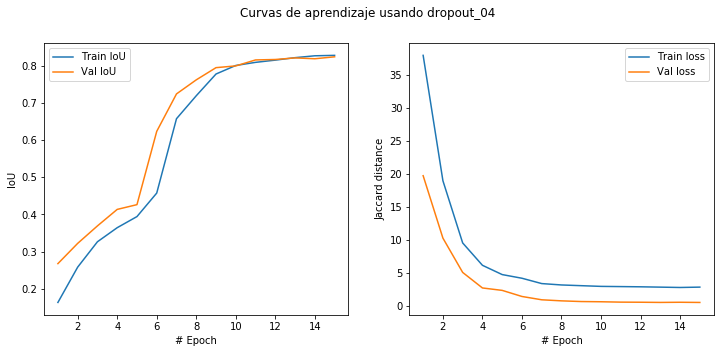

In [0]:
import matplotlib.pyplot as plt
import pickle
model = "dropout_04"
model_name = model + '.pkl'
with open(directory + 'results/history/' + model_name, 'rb') as f:
  history = pickle.load(f)


# Plotting the learning curve
epochs = list(range(1, len(history['dice_coef'])+1))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# IoU
axs[0].plot(epochs, history['per_class_iou'], label="Train IoU")
axs[0].plot(epochs, history['val_per_class_iou'], label= "Val IoU")
axs[0].set_xlabel("# Epoch")
axs[0].set_ylabel("IoU")
axs[0].legend()

# Loss
axs[1].plot(epochs, history['loss'], label="Train loss")
axs[1].plot(epochs, history['val_loss'], label= "Val loss")
axs[1].set_xlabel("# Epoch")
axs[1].set_ylabel("Jaccard distance")
axs[1].legend()

fig.suptitle(f"Curvas de aprendizaje usando {model}")
plt.savefig(f"learning_curve_{model}.png", dpi=300)

Si desea cargar los pesos al modelo de tal manera de poder ejecutar predicciones ejecutar la siguiente celda.

In [0]:
model.load_weights('/content/drive/My Drive/myocardium-segmentation/results/models/jaccard_dropout_04_improved.h5')

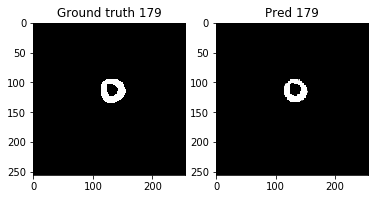

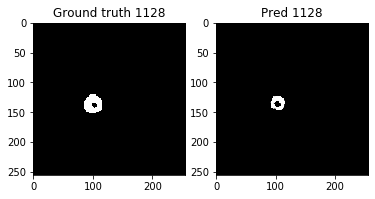

USING <function np_iou at 0x7f2373c8e6a8>
For class 0: 0.9970467460177995+-0.0016738340031767695
For class 1: 0.6792415195755334+-0.13022149449356693
For class 2: 0.8218970475131212+-0.15368136562319448
Mean and std of scores per class: 0.8327284377021513
Global IoU: 0.991416800875281 +/- 0.0042536048688753495


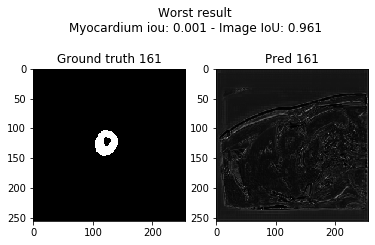

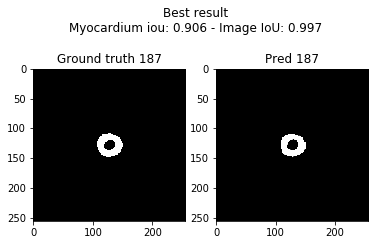

------------------------------
USING <function np_dice_coef at 0x7f2373c8e730>
For class 0: 0.9985204721844391+-0.0008418873197393695
For class 1: 0.7994386242683184+-0.1235178088298162
For class 2: 0.8900972799825844+-0.13901450838632753
Mean and std of scores per class: 0.896018792145114
Global IoU: 0.995685260951297 +/- 0.0021578242278109715


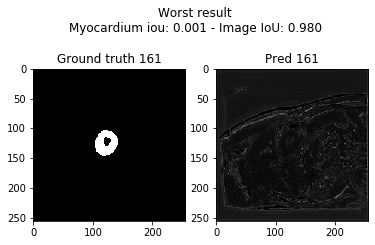

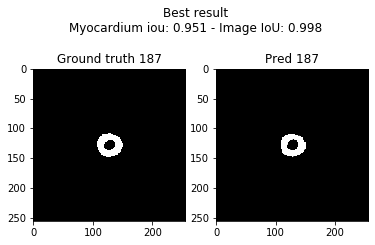

------------------------------
USING <function np_iou_thresholded at 0x7f232f02fd08>
For class 0: 0.997086024909646+-0.0016762554526631986
For class 1: 0.6812982200181925+-0.13055060532743878
For class 2: 0.8244466107879879+-0.15371475296751202
Mean and std of scores per class: 0.8342769519052755
Global IoU: 0.9915034607280522 +/- 0.004263643286577219


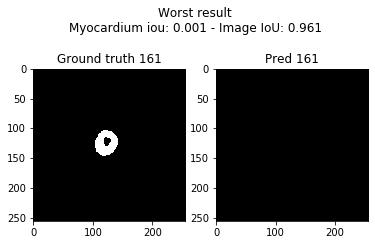

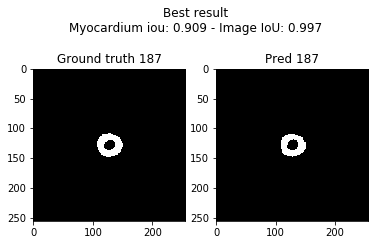

------------------------------


In [0]:
import matplotlib.pyplot as plt
ypred= model.predict(X_test)
extract_statistics(y_test,ypred,plot_examples=True, plot_best_worst=True)

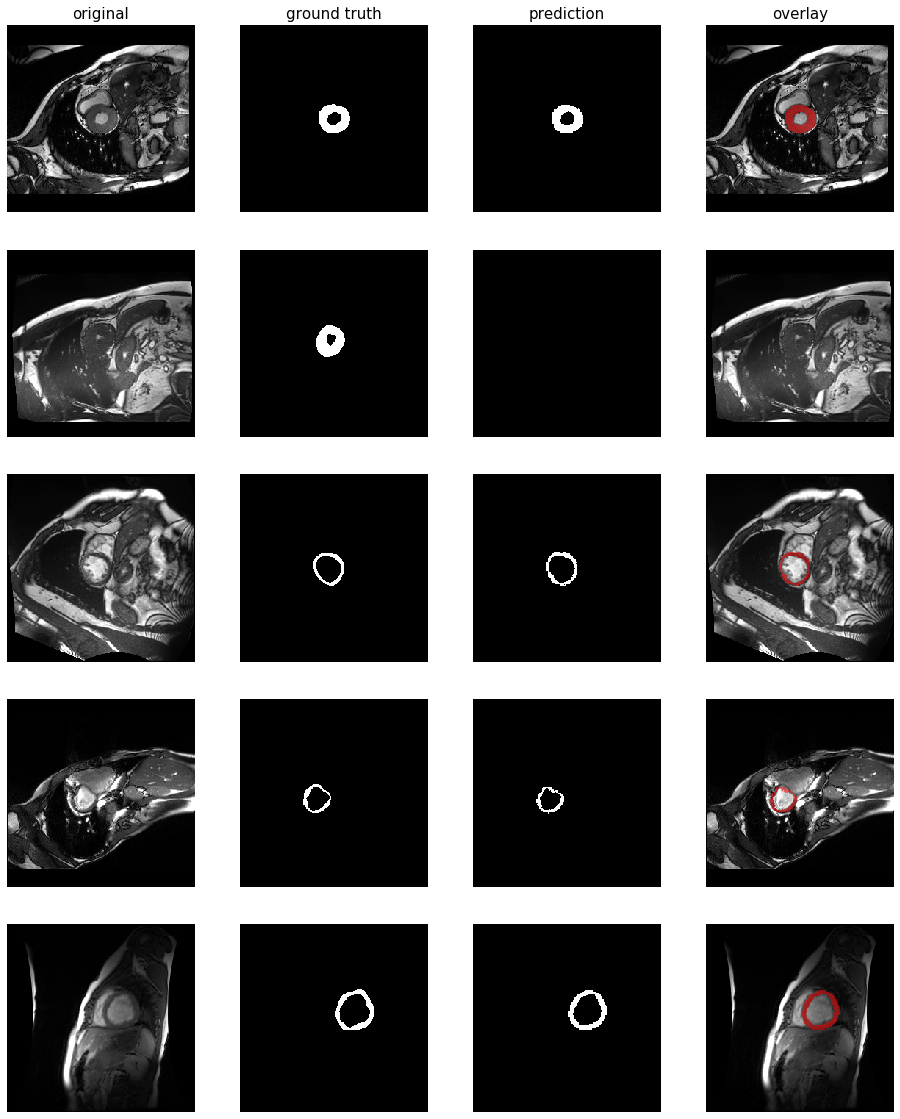

Img 187:
Class 0: 0.9988325576327381
Class 1: 0.9087656529516994
Class 2: 0.9035714285714286
Mean: 0.9370565463852887

Img 161:
Class 0: 0.9802554282313808
Class 1: 0.0008703220191470844
Class 2: 0.006802721088435374
Mean: 0.3293094904463211

Img 40:
Class 0: 0.9982211680996146
Class 1: 0.721183800623053
Class 2: 0.9284274193548387
Mean: 0.8826107960258355

Img 302:
Class 0: 0.9974912891986063
Class 1: 0.5286506469500925
Class 2: 0.8464912280701754
Mean: 0.7908777214062913

Img 400:
Class 0: 0.9973810012148367
Class 1: 0.7254725472547254
Class 2: 0.8970370370370371
Mean: 0.8732968618355331



In [0]:
# Plot using Keras_Unet utilities
from keras_unet.utils import plot_imgs
selected_imgs = [187, 161, 40, 302, 400]
plot_imgs(X_test[selected_imgs, :, :, 0], y_test[selected_imgs, :, :, 1], ypred[selected_imgs, :, :, 1], nm_img_to_plot=5)


# Printing imgs metrics
for idx in selected_imgs:
  img_test = y_test[idx, :, :, :]
  img_pred = ypred[idx, :, :, :]

  print(f"Img {idx}:")
  iou_values = []
  for channel in range(3):
    channel_iou = np_iou(img_test[:, :, channel], img_pred[:, :, channel])
    print(f"Class {channel}: {channel_iou}")
    iou_values.append(channel_iou)
  print(f"Mean: {np.mean(iou_values)}\n")




